# L'impact de la présence d'espaces verts sur l'appréciation de leur quartier par les résidents

## I- La localisation des espaces verts dans Paris

In [85]:
'''Thanks to the data retrieved from Paris OpenData and the geopandas library, we will analyse the location of green spaces in Paris'''
'''Importing packages'''
!pip install contextily
!pip install pandas fiona shapely pyproj rtree
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from cartiflette.s3 import download_vectorfile_url_all


  Cloning https://github.com/inseefrlab/cartiflette (to revision 80b8a5a28371feb6df31d55bcc2617948a5f9b1a) to /tmp/pip-req-build-9n0n259k
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-9n0n259k
  Running command git rev-parse -q --verify 'sha^80b8a5a28371feb6df31d55bcc2617948a5f9b1a'
  Running command git fetch -q https://github.com/inseefrlab/cartiflette 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Running command git checkout -q 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Resolved https://github.com/inseefrlab/cartiflette to commit 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [86]:
'''Let's download the geographical data of Paris to create its map'''
Paris_borders = download_vectorfile_url_all(crs = 4326,values = ["75"],borders="COMMUNE_ARRONDISSEMENT",vectorfile_format="topojson",filter_by="DEPARTEMENT",source="EXPRESS-COG-CARTO-TERRITOIRE",year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 40.1kiB [00:00, 33.6MiB/s]


In [87]:
''' Transform the geographical data into the Lambert 93 base'''
Paris_borders=Paris_borders.to_crs(2154)

### Aperçu du fichier recenssant les arrondissements de Paris et leurs coordonnées géorgraphiques:

In [88]:
Paris_borders.head()

,id,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,source,INSEE_COG,geometry
0,ARR_MUNI0000000009736045,NaN,Paris 3e Arrondissement,PARIS 3E ARRONDISSEMENT,75056,Capitale d'état,34025,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75103,"POLYGON ((652324.622 6862635.302, 652326.463 6..."
1,ARR_MUNI0000000009736046,NaN,Paris 2e Arrondissement,PARIS 2E ARRONDISSEMENT,75056,Capitale d'état,21595,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75102,"POLYGON ((652167.724 6863604.342, 652193.783 6..."
2,ARR_MUNI0000000009736545,NaN,Paris 4e Arrondissement,PARIS 4E ARRONDISSEMENT,75056,Capitale d'état,29131,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75104,"POLYGON ((653663.658 6861937.170, 653680.442 6..."
3,ARR_MUNI0000000009736544,NaN,Paris 5e Arrondissement,PARIS 5E ARRONDISSEMENT,75056,Capitale d'état,58227,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75105,"POLYGON ((651312.816 6860162.422, 651317.730 6..."
4,ARR_MUNI0000000009736543,NaN,Paris 6e Arrondissement,PARIS 6E ARRONDISSEMENT,75056,Capitale d'état,40303,NR,1,75,11,200054781,IGN:EXPRESS-COG-CARTO-TERRITOIRE,75106,"POLYGON ((651056.714 6862351.152, 651091.406 6..."


### Aperçu du fichier recensant les espaces verts de Paris et leurs coordonnées géographiques :

In [89]:
espaces_verts=gpd.read_file("data/espaces_verts.geojson").to_crs(2154) #On convertit les données géographiques au même format que celles des arrondissements
espaces_verts=espaces_verts[espaces_verts["adresse_codepostal"].apply(lambda x:str(x).startswith("75"))]
espaces_verts.head()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "fiona/ogrext.pyx", line 136, in fiona.ogrext.gdal_open_vector
  File "fiona/_err.pyx", line 291, in fiona._err.exc_wrap_pointer
fiona._err.CPLE_OpenFailedError: data/espaces_verts.geojson: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_268/2724504569.py", line 1, in <module>
    espaces_verts=gpd.read_file("data/espaces_verts.geojson").to_crs(2154) #On convertit les données géographiques au même format que celles des arrondissements
  File "/opt/mamba/lib/python3.10/site-packages/geopandas/io/file.py", line 297, in _read_file
    if from_bytes:
  File "/opt/mamba/lib/python3.10/site-packages/geopandas/io/file.py", line 338, in _read_file_fiona
  File "/opt/mamba/lib/python3.10/site

### Carte représentant la localisation des espaces verts dans les arrondissements de Paris:

In [56]:
'''Creating the center points of each arrondissement'''
centre_arrondissements=Paris_borders["geometry"].representative_point().to_frame().set_index(Paris_borders["NOM"])

In [57]:
centre_arrondissements = centre_arrondissements.reset_index().rename(columns={0: "centroid"})
centre_arrondissements = centre_arrondissements.set_geometry("centroid")

In [66]:
from shapely import get_x, get_y

Text(0.5, 1.0, 'Espaces verts de Paris')

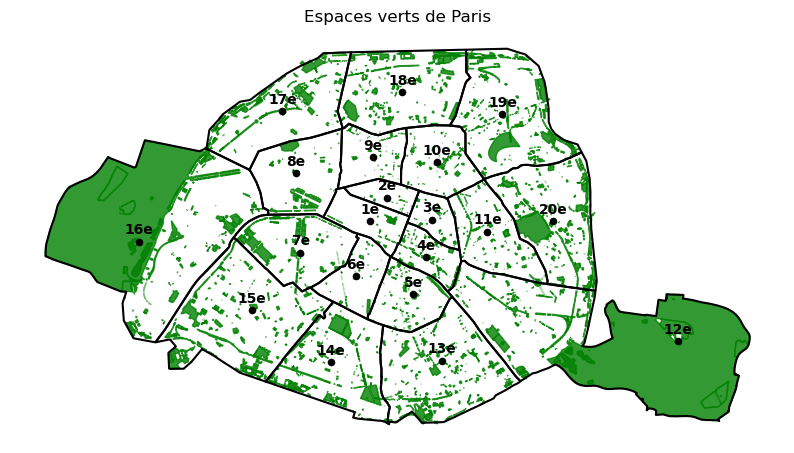

In [84]:
'''Ploting the whole graph of green spaces in Paris'''
fig,ax = plt.subplots(figsize=(10,10))
espaces_verts.plot(ax=ax,alpha=0.8,edgecolor='green',facecolor='green') #On affiche les espaces verts
Paris_borders.boundary.plot(ax = ax, edgecolor = "black", facecolor="none",color =None) #On affiche les bordures des arrondissements
centre_arrondissements.plot(ax=ax,color="black",markersize=20)
'''Loop to print the name of arrondissements on the map '''
for idx, row in centre_arrondissements.iterrows():
    coords = (get_x(row["centroid"]), get_y(row["centroid"]) + 200)
    if 'e' in row['NOM'][6:8]:
        text= row['NOM'][6:8]
    else:
        text=row['NOM'][6:9]
    plt.annotate(text=text, xy=coords,
                 horizontalalignment='center',fontweight=550)
ax.set_axis_off()
ax.set_title("Espaces verts de Paris") 
#ax.legend()


# II- Relation entre la surface verte et les notes de l'arrondissement

In [9]:
'''We group the green spaces data by arrondissement and compute the total green area'''
surface_verte= espaces_verts.groupby("adresse_codepostal")["surface_totale_reelle"].sum().to_frame().sort_values(by="surface_totale_reelle",ascending=False) #On somme et on trie dans l'ordre décroissant de la surface totale

### Classement des arrondissements selon la surface verte totale :

In [10]:
surface_verte

,surface_totale_reelle
adresse_codepostal,
75012,952968.0
75020,797930.0
75016,788740.0
75015,745832.0
75019,584801.0
75014,575442.0
75017,429355.0
75007,396466.0
75013,388920.0


In [11]:
notes_env=pd.read_excel("data/Notes_arrondissements.xlsx")["Environnement"].to_frame()

In [12]:
'''We create a dictionary for the name of arrondissements to have the same nomenclatures in all tables'''
dict_arrondissements={}
for i in range(9):
    dict_arrondissements[i]='7500'+str(i+1)
for i in range(9,20):
    dict_arrondissements[i]='750'+str(i+1)

### Classement des arrondissements selon la note donnée au critère "Environnement" sur ville-ideale.fr :

In [13]:
notes_env=notes_env.rename(index= dict_arrondissements).sort_values(by="Environnement",ascending=False)
notes_env['Environnement']=notes_env['Environnement'].apply(lambda x:float(x.replace(',','.')))
notes_env

,Environnement
75016,7.38
75005,7.30
75007,6.88
75012,6.80
75008,6.78
75006,6.25
75015,6.20
75017,6.02
75003,5.52
75019,5.43


### Classement des arrondissements selon la note globale donnée sur ville-ideale.fr :

In [14]:
notes_globales=pd.read_excel("Notes_arrondissements.xlsx")["Note Globale"].to_frame()

In [15]:
notes_globales=notes_globales.rename(index= dict_arrondissements).sort_values(by="Note Globale",ascending=False)
notes_globales['Note Globale']=notes_globales['Note Globale'].apply(lambda x:float(x.replace(',','.')))
notes_globales

,Note Globale
75005,8.32
75008,7.76
75003,7.65
75006,7.65
75015,7.49
75012,7.48
75016,7.38
75007,7.30
75009,7.25
75017,7.18


### Jonction des trois tableaux :

In [16]:
tableau=pd.merge(surface_verte,notes_env.join(notes_globales),left_index=True,right_index=True).sort_index() #On merge tous les tableaux ensemble selon l'index(l'arrondissement)

In [17]:
tableau

,surface_totale_reelle,Environnement,Note Globale
75001,49979.0,4.50,6.58
75002,3485.0,3.13,6.23
75003,28342.0,5.52,7.65
75004,69836.0,4.27,6.09
75005,84995.0,7.30,8.32
75006,31441.0,6.25,7.65
75007,396466.0,6.88,7.30
75008,253567.0,6.78,7.76
75009,19645.0,5.14,7.25
75010,63637.0,3.24,5.10


### Représentations graphiques :

Text(0.5, 0.98, 'Notes données sur ville-ideale.fr en fonction de la surface totale des espaces verts')

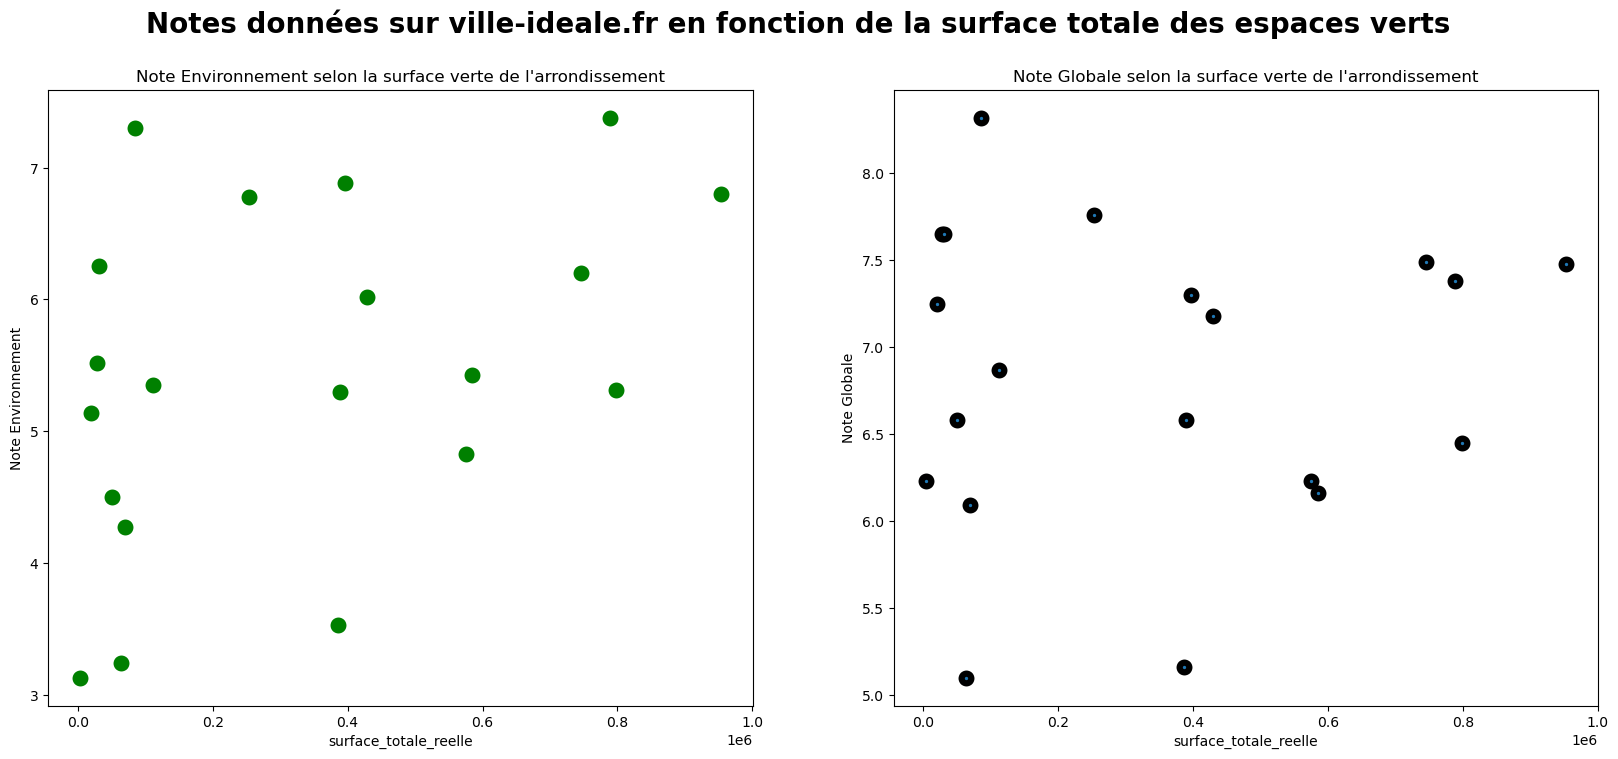

In [18]:
fig,ax=plt.subplots(1,2,figsize=(20,8))
tableau.plot(ax=ax[0],kind='scatter',x="surface_totale_reelle",y='Environnement',ylabel='Note Environnement',linewidths=7,color='green')
tableau.plot(ax=ax[1],kind='scatter',x="surface_totale_reelle",y='Note Globale',ylabel='Note Globale',linewidths=7,edgecolor='black')
ax[0].set_title("Note Environnement selon la surface verte de l'arrondissement")
ax[1].set_title("Note Globale selon la surface verte de l'arrondissement")
fig.suptitle("Notes données sur ville-ideale.fr en fonction de la surface totale des espaces verts",fontsize=20,fontweight='bold')

#### Nous n'observons pas de corrélation entre la surface verte dans un arrondissement et la note donnée par ses habitants, ni pour la note d'environnement, ni pour la note globale. Cependant, nous pouvons constater que lorsque la surface verte est très importante $(>0,6 \times 10^6)$, il n'y a aucune note en dessous de la moyenne. Par contre, certains arrondissements avec très peu de surface verte obtiennent de très hautes notes. Nous pouvons donc conclure que la quantité d'espaces verts dans un arrondissement n'est pas nécessaire à son appréciation par les habitants mais une forte quantité d'espaces verts garantit un niveau minimal de satisfaction.

#### Ceci peut se vérifier géographiquement en remarquant que les arrondissements avec une surface verte plus importante ne sont pas forcément les mieux notés globalement comme en terme d'environnement :

In [19]:
'''Function that eliminates the 'e' after the name of arrondissements in the column 'NOM_M' of the Paris_borders dataframe'''
def numero(i:str):
    if i[1]=='E':
        return i[0]
    else:
        return i
    

In [20]:
'''Determining the postal codes of arrondissements by their number'''
def postal_code(i):
    if i in range(1,10):
        return "750"+"0"+ str(i)
    else:
        return "750"+str(i)

Text(0.5, 0.98, "Comparaison spatiale entre la quantité d'espaces verts et les notes données aux arrondissements de Paris")

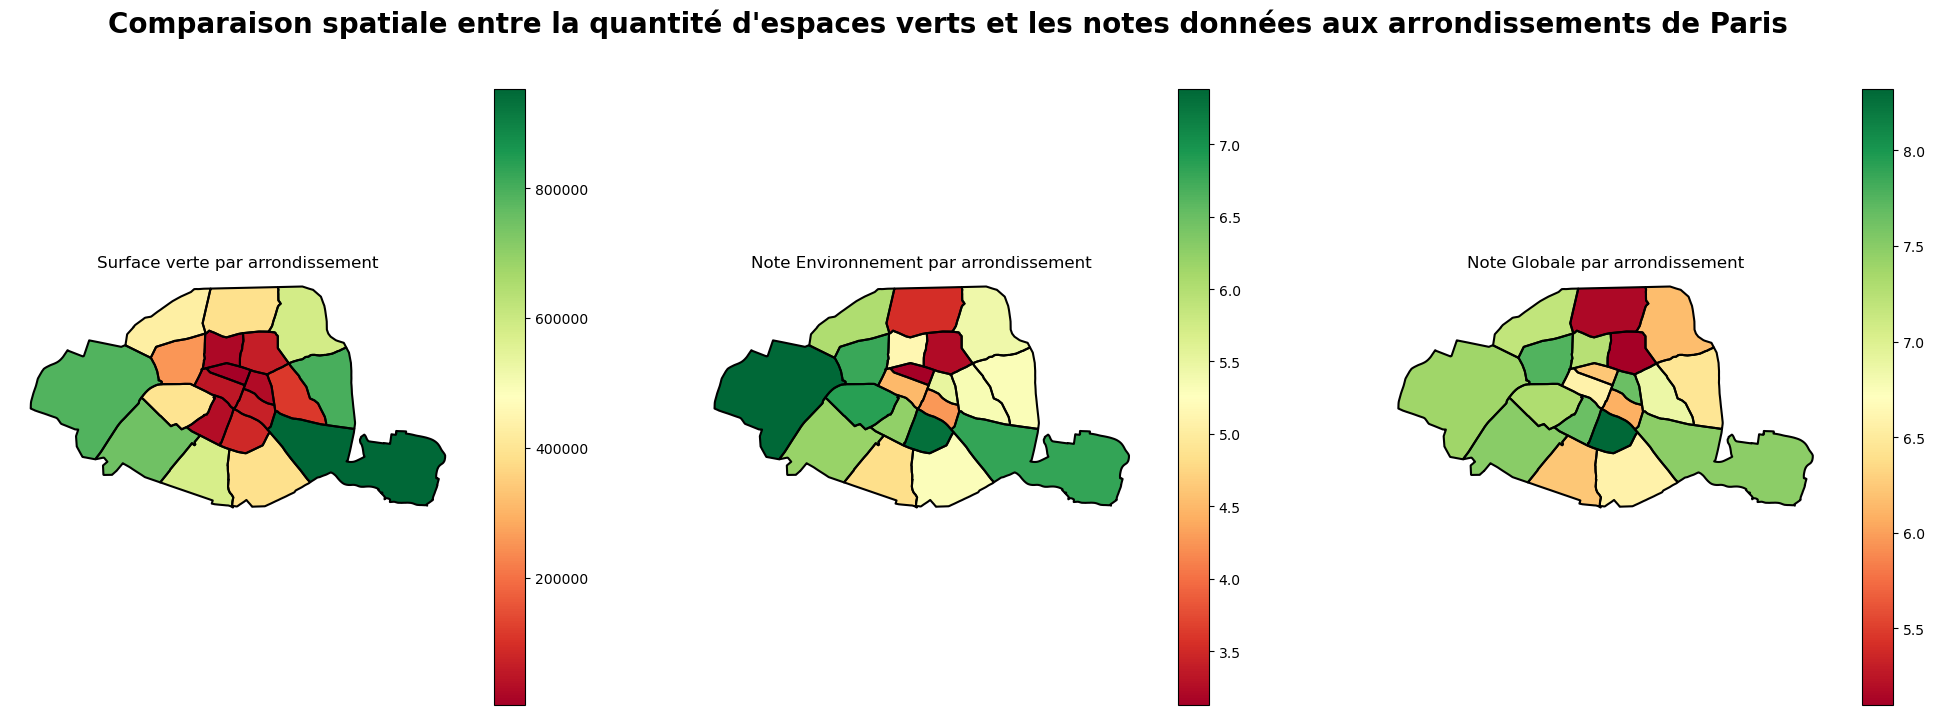

In [25]:
'''Creating 3 map graphs to visualise the arrondissement that have more green spaces or higher marks'''

fig,ax=plt.subplots(1,3,figsize=(25,8))

'''Giving the Paris_borders geo-dataframe the same index (postal codes) as our other dataframes'''

Paris_borders_everts=Paris_borders.dissolve('NOM','sum')
Paris_borders_everts['NOM_M']=Paris_borders_everts['NOM_M'].apply(lambda x: postal_code(int(numero(x[6:8])))) #Transforming the column 'NOM_M' into postal codes
Paris_borders_everts=Paris_borders_everts.set_index('NOM_M').sort_index() #We sort the postal codes to facilitate the joining with other tables
'''We add 3 columns to our new Paris_borders_everts dataframe : the total green area, the environmental mark and the global mark for each arrondissement''' 

Paris_borders_everts['Surface verte']=surface_verte.sort_index()['surface_totale_reelle']
Paris_borders_everts['Note Environnement']=notes_env.sort_index()['Environnement']
Paris_borders_everts['Note Globale']=notes_globales.sort_index()['Note Globale']

'''We plot each map graph and choose the colors of the legend(going from red to dark green)'''

Paris_borders_everts.plot(column='Surface verte',ax=ax[0],legend=True,cmap='RdYlGn')
ax[0].set_title('Surface verte par arrondissement')
Paris_borders_everts.plot(column='Note Environnement',ax=ax[1],legend=True,cmap='RdYlGn')
ax[1].set_title('Note Environnement par arrondissement')
Paris_borders_everts.plot(column='Note Globale',ax=ax[2],legend=True,cmap='RdYlGn')
ax[2].set_title('Note Globale par arrondissement')
for axx in ax:
    axx.set_axis_off()
    Paris_borders.boundary.plot(ax = axx, edgecolor = "black", facecolor="none",color =None) #Print the borders of arrondissements
fig.suptitle("Comparaison spatiale entre la quantité d'espaces verts et les notes données aux arrondissements de Paris",fontsize=20,fontweight='bold')

#### On observe géographiquement le même résultat : Les couleurs des arrondissements diffèrent en général sur les 3 cartes donc on ne peut pas voir de corrélation entre surface verte et note donnée, mais les arrondissements les plus verts sont bien notés.